### Import libraries

In [1]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 

from xgboost import XGBClassifier

# import own modules
sys.path.append("..")  # Adds higher directory to python modules path.
from scripts import features as ft
from scripts import preprocessing as pp
from scripts import evaluate_models as em

#plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

import pickle

---
## Preparations

### Load the CSV into a Dataframe

- load csv (or calculate again if not in data folder)
- update index=id
- drop useless columns
- find numerical & object columns

In [2]:
# path to csv file
path_df = os.path.join("..", "data", "df_deepgaze2e.csv")

# get features - or recalculate
recalculate_df = False
if os.path.isfile(path_df) and not recalculate_df:
    df = pd.read_csv(path_df)
else:
    df = ft.get_features()
    df.to_csv(path_df, index=False)

# set id as index
df = df.set_index("id", drop=True)

# drop first batch of useless variables
df = df.drop(columns=['img', 'sp_idx'])
df = df.drop(columns=[col for col in df.columns if "_obj" in col])  # drop 'object' columns

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

 -> dataframe has 7598 instances and 34 columns
 -> there are 34 numerical columns
 -> there are 0 categoricals columns


### First, drop instances & features

- unusual long fixation durations are identified as outliers and dropped
  - drop if "dur > 5000 ms"
- drop `sal_first_above_0.75*max_rank` & `sal_first_above_0.9*max_rank` since this features consists of mainly (33% / 61%) outlier values
  - outliers are coded as "20" 


In [3]:
# processing
df = df[df["sp_fix_duration_ms_total"] <= 5000]
df = df.drop(columns=['sal_first_above_0.75*max_rank', 'sal_first_above_0.9*max_rank'])

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

 -> dataframe has 7217 instances and 32 columns
 -> there are 32 numerical columns
 -> there are 0 categoricals columns


### Checking for highly correlated columns
think after running this lines, which column to additionally drop

Correlation between sp_fix_duration_ms_total and sal_weighted_duration_sum is 0.828
Correlation between sp_fix_duration_ms_mean and sal_weighted_duration_mean is 0.815
Correlation between obj_n_fix_face and obj_t_abs_on_face is 0.822
Correlation between obj_n_fix_face and obj_t_rel_on_face is 0.801
Correlation between obj_n_fix_inanimate and obj_t_abs_on_inanimate is 0.868
Correlation between obj_n_fix_inanimate and obj_t_rel_on_inanimate is 0.841
Correlation between obj_n_fix_background and obj_t_abs_on_background is 0.84
Correlation between obj_n_fix_background and obj_t_rel_on_background is 0.804


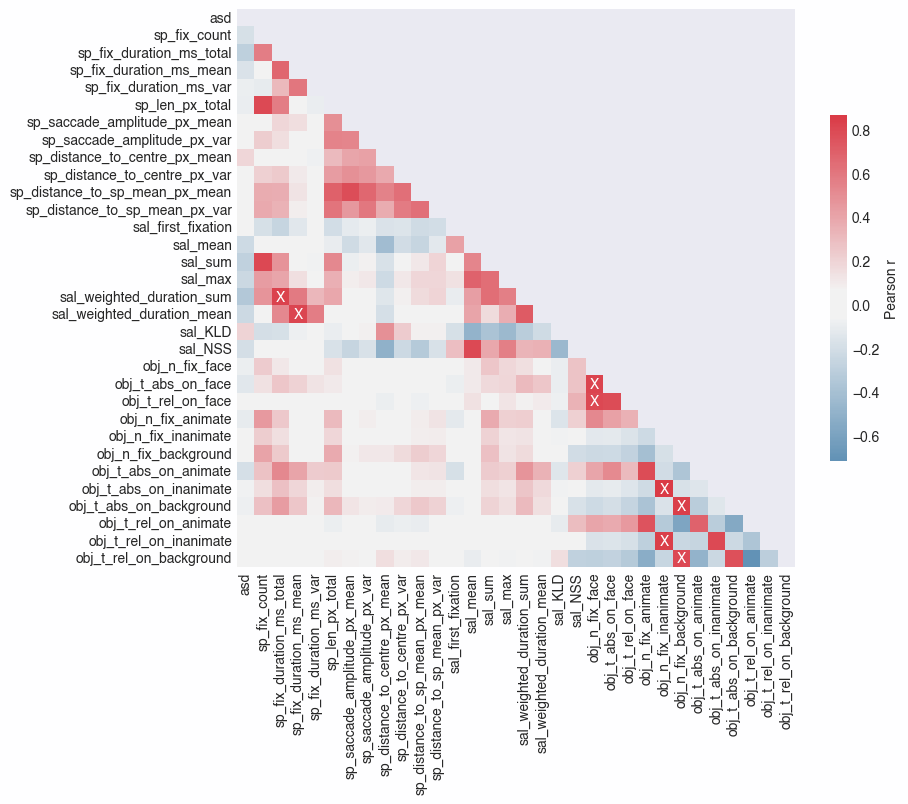

In [4]:
# check for correlations
pp.check_correlations(df[num_cols], thresh=0.8)

### further processing of correlating features
- `sp_fix_duration_ms_total` & `sp_fix_duration_ms_mean`
  - keep the `saliency weighted` version of both fixation duration measures
- `obj_n_fix_*`
  - keep the time measures of object recognition features

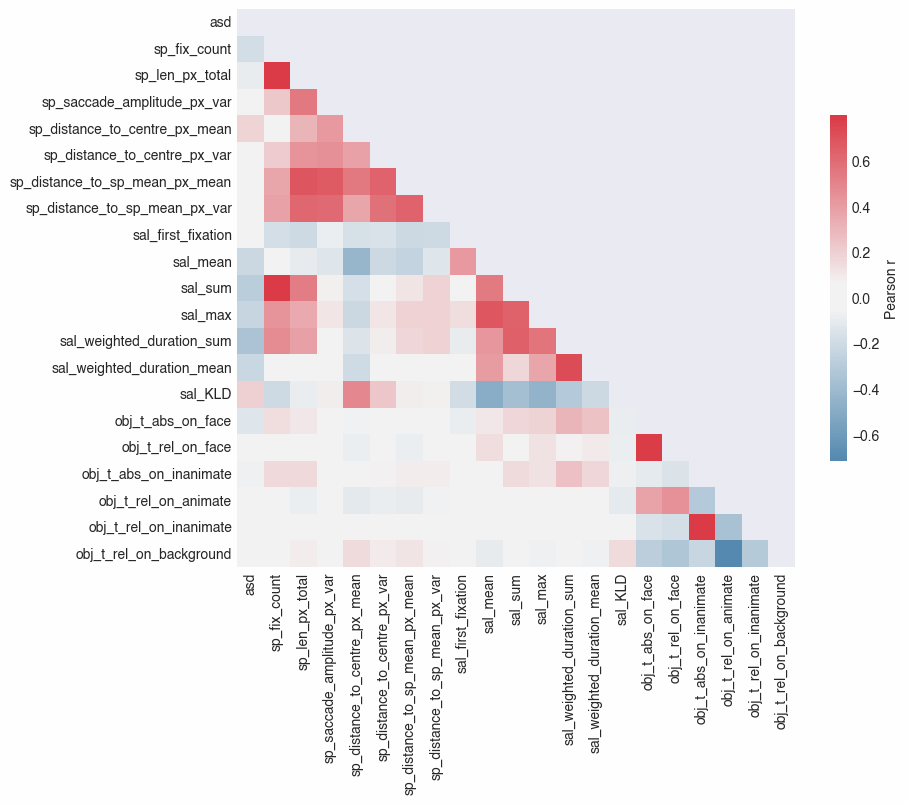

 -> dataframe has 7217 instances and 21 columns
 -> there are 21 numerical columns
 -> there are 0 categoricals columns


In [5]:
# processing
df = df.drop(
    columns=[
        "sp_fix_duration_ms_total",
        "sp_fix_duration_ms_mean",
        "obj_n_fix_face",
        "obj_n_fix_animate",
        "obj_n_fix_inanimate",
        "obj_n_fix_background",
        "sp_fix_duration_ms_var",
        "sp_saccade_amplitude_px_mean",
        "obj_t_abs_on_background",
        "obj_t_abs_on_animate",
        "sal_NSS",
       
    ]
)
# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# check for correlations, again
pp.check_correlations(df[num_cols], thresh=0.8)


# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

### Split into train & test sets

As soon as the dataset is in its final form, perform train-test-split with our own split function to have out 30-image-set always as our test set.

In [6]:
# prepare features and target
X = df
y = X.pop("asd")

num_cols = X.columns[X.dtypes != "object"]

# train-test-split
X_train, X_test, y_train, y_test = pp.split(X, y)

# print info
print(f"train-set has '{len(y_train)}' samples & '{X.shape[1]}' features")
print(f"test-set has '{len(y_test)}' samples - out of '{df.shape[0]}'")
print(f"  ~ {len(y_test) / df.shape[0] * 100:.2f}% of full dataset")

train-set has '6736' samples & '20' features
test-set has '481' samples - out of '7217'
  ~ 6.66% of full dataset


In [7]:
# train-test-split
X_train, X_test, y_train, y_test = pp.split(X, y)

### Set variables

- define `metric`
- behavior for saving models as pickles
- defaults for model-objects

In [8]:
# metric
ftwo_scorer = make_scorer(fbeta_score, beta=2)

# defaults
RSEED = 42
cv = 10
n_jobs = -1
verbose = 1

# Modeling preparation

In [9]:
# add other transformations at the end if needed
transformer = [("scaler", MinMaxScaler(), num_cols),
               ("ohe", OneHotEncoder(drop="first"), cat_cols  )]
               
preprocessing = ColumnTransformer(transformer,
                                  remainder="passthrough")

### Pipeline

In [10]:
# XGBoost: apply scaling / encoding
xgb_pipeline = Pipeline([
    ("preprocessor", preprocessing),
    ("classifier", XGBClassifier())
])

### Parameter grid

In [11]:
# XGBoost
param_grid_xgb = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [3, 5, 7, None],
    "classifier__learning_rate": [0.1, 0.01, 0.001]
}

In [12]:
# Create GridSearchCV object
grid_search_xgb = GridSearchCV(
    xgb_pipeline,
    param_grid=param_grid_xgb,
    cv=cv,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=verbose,
    error_score='raise'
)
grid_search_xgb.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params_xgb = grid_search_xgb.best_params_
best_est_xgb = grid_search_xgb.best_estimator_
print("Best params for XGB are:", best_params_xgb)
print("Best est for XGB are:", best_est_xgb)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


/Users/eockfen/Desktop/neuefische/Capstone_project/.venv/lib/python3.11/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/Users/eockfen/Desktop/neuefische/Capstone_project/.venv/lib/python3.11/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best params for XGB are: {'classifier__learning_rate': 0.01, 'classifier__max_depth': None, 'classifier__n_estimators': 100}
Best est for XGB are: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', MinMaxScaler(),
                                                  Index(['sp_fix_count', 'sp_len_px_total', 'sp_saccade_amplitude_px_var',
       'sp_distance_to_centre_px_mean', 'sp_distance_to_centre_px_var',
       'sp_distance_to_sp_mean_px_mean', 'sp_distance_to_sp_mean_px_var',
       'sal_first_fixation', 'sal_mean', 'sal_su...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
   

Best params for XGB are: {'classifier__learning_rate': 0.01, 'classifier__max_depth': None, 'classifier__n_estimators': 200}
Best est for XGB are: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', MinMaxScaler(),
                                                  Index(['sp_fix_count', 'sp_fix_duration_ms_var', 'sp_len_px_total',
       'sp_saccade_amplitude_px_mean', 'sp_saccade_amplitude_px_var',
       'sp_distance_to_centre_px_mean', 'sp_distance_to_centre_px_var',
       'sp_distance_to_sp_mean_px_mean', 'sp_distance_to...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [13]:
# predict & proba
pred_test = grid_search_xgb.predict(X_test)
proba_test = grid_search_xgb.predict_proba(X_test)

pred_train = grid_search_xgb.predict(X_train)
proba_train = grid_search_xgb.predict_proba(X_train)

In [14]:
y_test_results = y_test.to_frame()

In [15]:
y_test_results['prediction']= pred_test

In [16]:
y_test_results

,asd,prediction
id,,
asd_112_01,1,0
asd_112_02,1,0
asd_112_03,1,1
asd_112_04,1,1
asd_112_05,1,1
...,...,...
td_287_06,0,0
td_287_07,0,0
td_287_08,0,1


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.748     0.743     0.745      3379
           1      0.743     0.748     0.745      3357

    accuracy                          0.745      6736
   macro avg      0.745     0.745     0.745      6736
weighted avg      0.745     0.745     0.745      6736

f(0.5)-score: 0.744
f(2.0)-score: 0.747

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.710     0.701     0.705       244
           1      0.696     0.705     0.700       237

    accuracy                          0.703       481
   macro avg      0.703     0.703     0.703       481
weighted avg      0.703     0.703     0.703       481

f(0.5)-score: 0.698
f(2.0)-score: 0.703



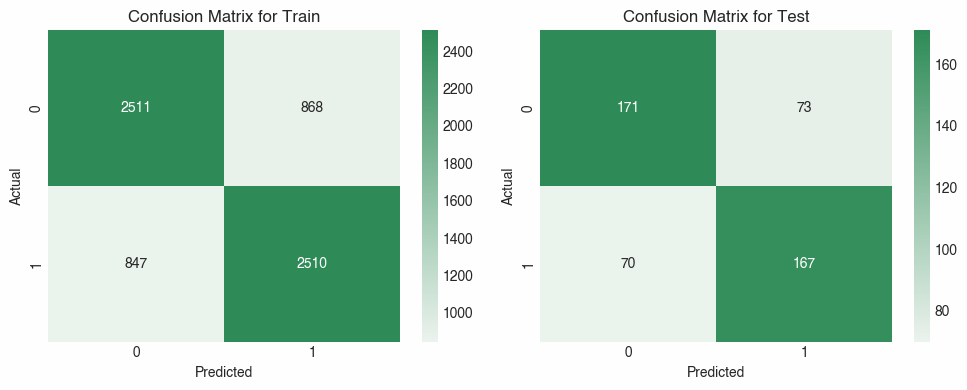

------------------------------------------------------------
'Train': ROC AUC score = 0.745
'Test': ROC AUC score = 0.703


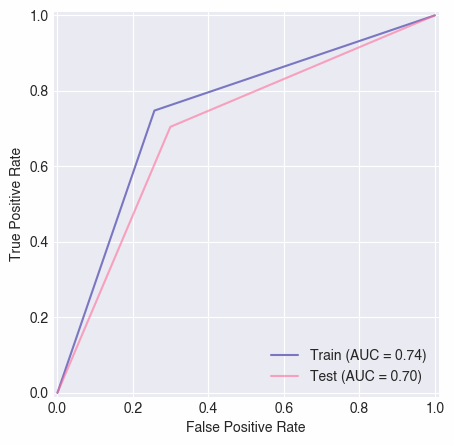

In [17]:
# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

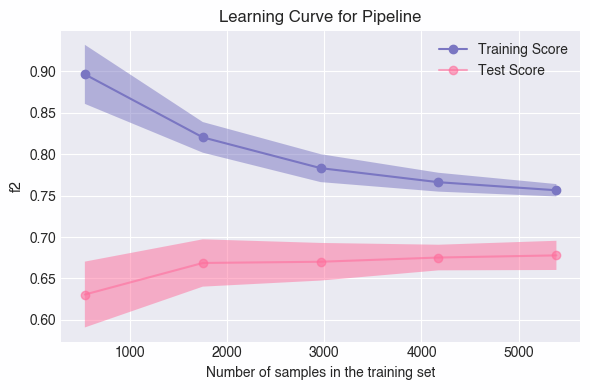

In [18]:
# learning curves - for one model - f2 score
em.learning(best_est_xgb, X_train, y_train)

### Feature importance using permutation importance 

/Users/eockfen/Desktop/neuefische/Capstone_project/.venv/lib/python3.11/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


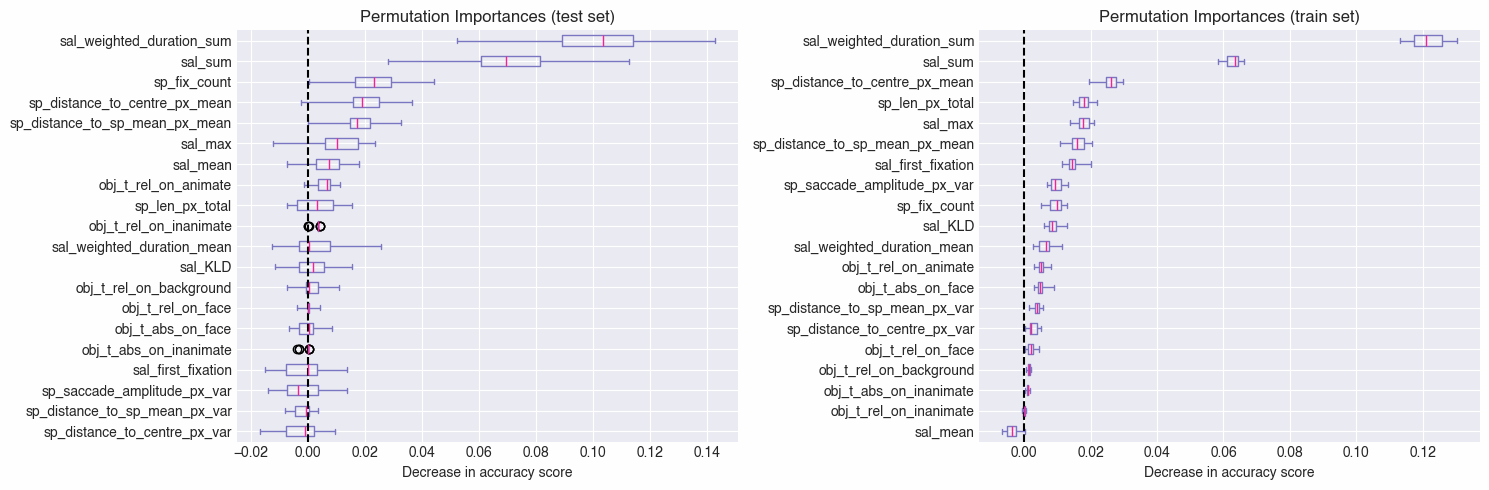

In [19]:
from sklearn.inspection import permutation_importance
#calculate permutation importance for test data 
result_test = permutation_importance(
    grid_search_xgb, X_test, y_test, n_repeats=20, random_state=42, n_jobs=2
)

sorted_importances_idx_test = result_test.importances_mean.argsort()
importances_test = pd.DataFrame(
    result_test.importances[sorted_importances_idx_test].T,
    columns=X.columns[sorted_importances_idx_test],
)

#calculate permutation importance for training data 
result_train = permutation_importance(
    grid_search_xgb, X_train, y_train, n_repeats=20, random_state=42, n_jobs=2
)

sorted_importances_idx_train = result_train.importances_mean.argsort()
importances_train = pd.DataFrame(
    result_train.importances[sorted_importances_idx_train].T,
    columns=X.columns[sorted_importances_idx_train],
)

f, axs = plt.subplots(1,2,figsize=(15,5))

importances_test.plot.box(vert=False, whis=10, ax = axs[0])
axs[0].set_title("Permutation Importances (test set)")
axs[0].axvline(x=0, color="k", linestyle="--")
axs[0].set_xlabel("Decrease in accuracy score")
axs[0].figure.tight_layout()

importances_train.plot.box(vert=False, whis=10, ax = axs[1])
axs[1].set_title("Permutation Importances (train set)")
axs[1].axvline(x=0, color="k", linestyle="--")
axs[1].set_xlabel("Decrease in accuracy score")
axs[1].figure.tight_layout()

remove: sp_fix_duration_ms_var, sp_saccade_amplitude_px_mean, obj_t_abs_on_background, obj_t_abs_on_animate, sal_NSS, sal_weighted_duration_mean, sal_mean, obj_t_rel_on_background, sp_distance_to_so_mean_px_var, sp_distance_to_centre_px_var

### Trying to fine-tune hyperparamters

In [20]:
from sklearn.preprocessing import StandardScaler
xgb = Pipeline(steps=[
    ('preprocessor', StandardScaler()),  
    ('classifier', XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=200, reg_lambda=3))
])

# Fit the pipeline to your data
xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', StandardScaler()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [21]:
# predict & proba
pred_test = grid_search_xgb.predict(X_test)
proba_test = grid_search_xgb.predict_proba(X_test)

pred_train = grid_search_xgb.predict(X_train)
proba_train = grid_search_xgb.predict_proba(X_train)

-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.748     0.743     0.745      3379
           1      0.743     0.748     0.745      3357

    accuracy                          0.745      6736
   macro avg      0.745     0.745     0.745      6736
weighted avg      0.745     0.745     0.745      6736

f(0.5)-score: 0.744
f(2.0)-score: 0.747

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.710     0.701     0.705       244
           1      0.696     0.705     0.700       237

    accuracy                          0.703       481
   macro avg      0.703     0.703     0.703       481
weighted avg      0.703     0.703     0.703       481

f(0.5)-score: 0.698
f(2.0)-score: 0.703



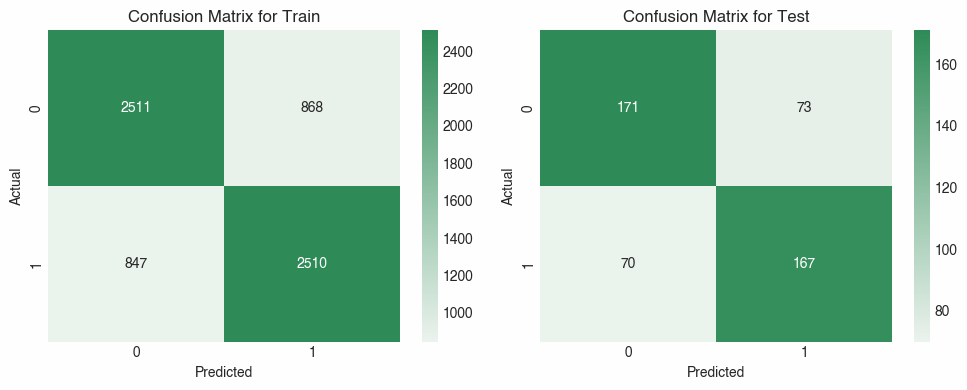

------------------------------------------------------------
'Train': ROC AUC score = 0.745
'Test': ROC AUC score = 0.703


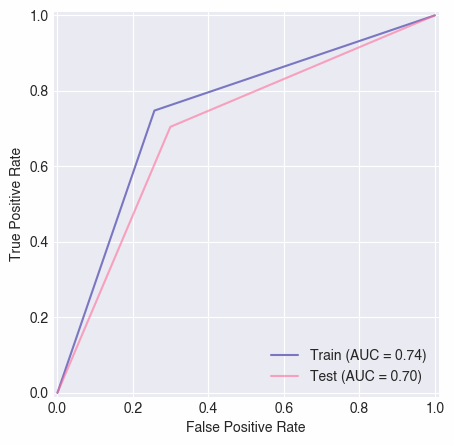

In [22]:
# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

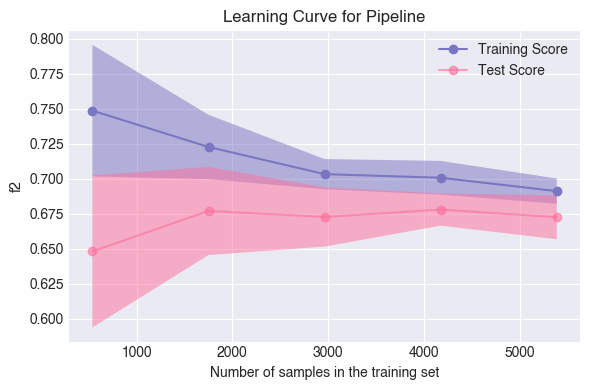

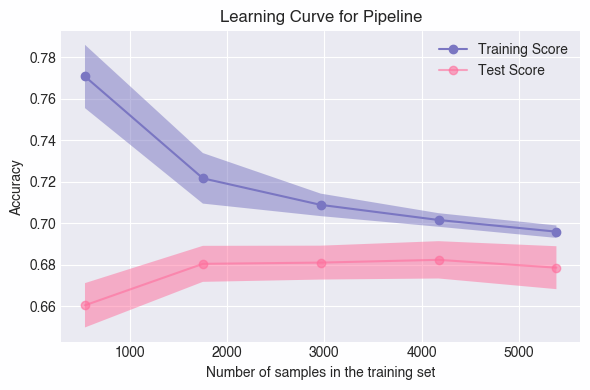

In [29]:
# learning curves - for one model - default score = f2
em.learning(xgb, X_train, y_train)

# learning curves - for one model - accuracy score
em.learning(xgb, X_train, y_train, score='accuracy', score_name="Accuracy")


#### Some model infos

In [30]:
# print some model infos   -> let me know what i should add !?!?!?
em.model_info(xgb)

#### Saving the model

In [28]:
# save model
model_name = "xgb.pickle"
em.save_model(_dt, model_name)

# save into specific folder
model_folder = "testing"
em.save_model(_dt, model_name, folder=model_folder)

# save again -> suffix will be added
em.save_model(_dt, model_name, folder=model_folder)

# save again & OVERWRITE
em.save_model(_dt, model_name, folder=model_folder, overwrite=True)

 -> model saved in: '../models/xgb.pickle'
 -> model saved in: '../models/testing/xgb.pickle'
 -> model saved in: '../models/testing/xgb_1.pickle'
 -> model saved in: '../models/testing/xgb.pickle'
